**Using LSTM to predict the adjusted closing price to get a better idea of the overall value of the stock.
Data used is from https://finance.yahoo.com/quote/%5EGSPC/history**

A bit more abour S&P 500 : The S&P 500 Index, or Standard & Poor's 500 Index, is a market-capitalization-weighted index of 500 leading publicly traded companies in the U.S. It is not an exact list of the top 500 U.S. companies by market cap because there are other criteria to be included in the index. The index is regarded as one of the best gauges of large-cap U.S. equities.


In [128]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
from keras.models import load_model
import keras
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import pandas_datareader.data as web
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


Normalizing the data.
historical GSPC data from yahoo finance:

In [129]:
df = pd.read_csv('^GSPC.csv')
dates = df["Date"].values
df.drop(['Volume', 'Close'], 1, inplace=True)
min_max_scaler = preprocessing.MinMaxScaler()
df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
df.head()


,Date,Open,High,Low,Adj Close
0,1990-01-02,0.021940,0.022065,0.021830,0.024373
1,1990-01-03,0.024321,0.022406,0.024075,0.024020
2,1990-01-04,0.023969,0.021713,0.022176,0.022848
3,1990-01-05,0.022799,0.020542,0.021591,0.021531
4,1990-01-08,0.021486,0.020000,0.021283,0.022134


In [ ]:
!pip3 install --upgrade pandas
!pip3 install --upgrade pandas-datareader

In [ ]:
import pandas_datareader.data as web
import datetime


start = datetime.datetime(2013, 1, 1)
end = datetime.date.today()
df = web.DataReader('^GSPC',"yahoo", start, end)
df.drop(['Volume', 'Close'], 1, inplace=True)
min_max_scaler = preprocessing.MinMaxScaler()
df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
df.head()

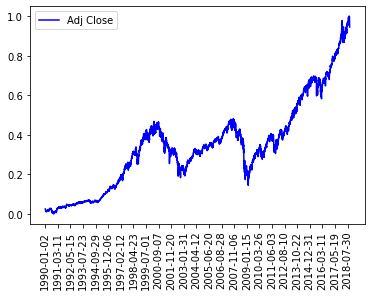

In [130]:
plt.plot(df['Date'],df['Adj Close'], color='blue', label='Adj Close')
plt.legend(loc='best')
plt.xticks(range(0,7252,300), df['Date'].values[::300], rotation = 90)#ticks every year once
plt.show()

Split the data into test and training.

In [133]:
df.drop(['Date'], 1, inplace=True)
ncolumns = len(df.columns)

windowed = []
# splitting into sequences of 30
for index in range(len(df) - 31): 
    windowed.append(df[index: index + 31]) 

windowed = np.array(windowed)
#windowed(ndata,which window, no of features)

#training 90% and test 10%

ntrain =round(0.9 * windowed.shape[0])
train = windowed[:ntrain, :,:] # 90% date, all features # (ntrain, 30, 4)
x_train = train[:, :-1] # x = all feature except adj close # (ntrain, 29, 4)
y_train = train[:, -1][:,-1] # y = last feature, last day (ntrain)
x_test = windowed[ntrain:, :-1] #(, 30, 4)
y_test = windowed[ntrain:, -1][:,-1] #(,)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], ncolumns))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], ncolumns))  










In [131]:
print(x_train.shape, x_test.shape, y_train.shape,y_test.shape)

(6499, 30, 4) (722, 30, 4) (6499,) (722,)


LSTM Network

In [121]:

model = Sequential()
    
model.add(LSTM(128, input_shape=(30,4), return_sequences=True))
model.add(Dropout(0.2))
        
model.add(LSTM(128, input_shape=(30,4), return_sequences=False))
model.add(Dropout(0.2))
        
model.add(Dense(64,kernel_initializer="uniform",activation='relu'))        
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

start = time.time()
model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
print("Compilation Time : ", time.time() - start)
model.summary()


Compilation Time :  0.004303932189941406


In [123]:
history1 = model.fit(
    x_train,
    y_train,
    batch_size=512,
    epochs=100,validation_split = 0.1)

Epoch 1/100
12/12 [==============================] - 9s 738ms/step - loss: 1.6654e-04 - accuracy: 1.7097e-04 - val_loss: 1.6497e-04 - val_accuracy: 0.0000e+00
Epoch 2/100
12/12 [==============================] - 9s 737ms/step - loss: 1.6607e-04 - accuracy: 1.7097e-04 - val_loss: 1.8302e-04 - val_accuracy: 0.0000e+00
Epoch 3/100
12/12 [==============================] - 9s 729ms/step - loss: 1.5721e-04 - accuracy: 1.7097e-04 - val_loss: 2.4301e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
12/12 [==============================] - 9s 738ms/step - loss: 1.7703e-04 - accuracy: 1.7097e-04 - val_loss: 2.5948e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
12/12 [==============================] - 9s 735ms/step - loss: 1.6862e-04 - accuracy: 1.7097e-04 - val_loss: 4.5201e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
12/12 [==============================] - 9s 732ms/step - loss: 1.8259e-04 - accuracy: 1.7097e-04 - val_loss: 6.7410e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
12/12 [===========================

In [124]:
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score MSE', trainScore[0])
print('Train Score RMSE',math.sqrt(trainScore[0]))

testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score MSE', testScore[0])
print('Test Score RMSE',math.sqrt(testScore[0]))

Train Score MSE 5.455789505504072e-05
Train Score RMSE 0.0073863316372229535
Test Score MSE 0.0005195944104343653
Test Score RMSE 0.022794613627661366


In [147]:
y_test.shape
dates[-722:].shape

(722,)

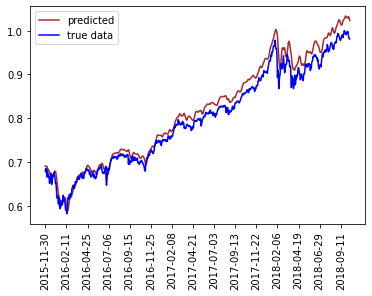

In [150]:
predicted = model.predict(x_test)
plt.plot(dates[-722:],predicted,color='brown', label='predicted')
plt.plot(dates[-722:].reshape((722,)),y_test,color='blue', label='true data')
plt.legend(loc='best')
plt.xticks(range(0,722,50), dates[-722:][::50], rotation = 90)#ticks every year once
plt.show()